<a href="https://colab.research.google.com/github/stop1one/DATA303/blob/main/Image_Generation_by_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generative Adversarial Networks (GANs)
======

This example is derived from 1. 'Deep Learning for Graphics Tutorial'.

Resources:

1.  CreativeAI: Deep Learning for Graphics Tutorial [[Link]](https://github.com/smartgeometry-ucl/dl4g)
2.  debuggercafe.com [[Link]](https://debuggercafe.com/vanilla-gan-pytorch/)

In [1]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib

from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

matplotlib.style.use('ggplot')

# 1. GAN (Deconv) with 64

### Hyperparameters


In [2]:
latent_dims = 100
num_epochs = 40
batch_size = 512
#batch_size = 128
learning_rate = 2e-4
use_gpu = True

### MNIST Data Loading

MNIST images show digits from 0-9 in 28x28 grayscale images. We scale to 64x64 so we can have a deeper architecture with more down-sampling steps. The images are normalized and centerd around 0, which gives a slight performance boost during training. We create both a training set and a test set.



In [31]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
def count_param(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### GAN Architecture
Like DCGAN, we use CNNs for generator and discriminator, which generally outperform vanilla GANs with fully connected layers.

In [32]:
class Generator(nn.Module):
    def __init__(self, ld, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(ld, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1) # 32 32 d
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1) # 16 16 2d
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1) # 8 8 4d
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1) # 4 4 8d
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0) # 1 1 1

    def forward(self, input):
        print("disc")
        print(input.size())
        x = F.leaky_relu(self.conv1(input), 0.2)
        print(x.size())
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        print(x.size())
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        print(x.size())
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        print(x.size())
        x = torch.sigmoid(self.conv5(x))
        print(x.size())

        return x
    
generator = Generator(ld=latent_dims)
discriminator = Discriminator()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = count_param(generator)
num_params_disc = count_param(discriminator)
print('Number of parameters for generator: {:,} and discriminator: {:,}'.format(num_params_gen, num_params_disc))

Number of parameters for generator: 12,656,257 and discriminator: 11,033,985


In [9]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), latent_dims, 1, 1, device=device)
        fake_image_batch = generator(latent)
        
        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1
        
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))

Training ...
Epoch [1 / 40] average loss generator vs. discrim.: 8.246344 vs. 0.038493
Epoch [2 / 40] average loss generator vs. discrim.: 7.581951 vs. 0.250768
Epoch [3 / 40] average loss generator vs. discrim.: 2.959078 vs. 0.509822
Epoch [4 / 40] average loss generator vs. discrim.: 1.657303 vs. 0.537391
Epoch [5 / 40] average loss generator vs. discrim.: 1.303244 vs. 0.599979
Epoch [6 / 40] average loss generator vs. discrim.: 1.190639 vs. 0.608749
Epoch [7 / 40] average loss generator vs. discrim.: 1.344629 vs. 0.559802
Epoch [8 / 40] average loss generator vs. discrim.: 1.275327 vs. 0.565088
Epoch [9 / 40] average loss generator vs. discrim.: 1.571868 vs. 0.534851
Epoch [10 / 40] average loss generator vs. discrim.: 1.520305 vs. 0.551736
Epoch [11 / 40] average loss generator vs. discrim.: 1.725149 vs. 0.509341
Epoch [12 / 40] average loss generator vs. discrim.: 2.150432 vs. 0.446434
Epoch [13 / 40] average loss generator vs. discrim.: 2.027633 vs. 0.466308
Epoch [14 / 40] avera

### Plot Training Curves

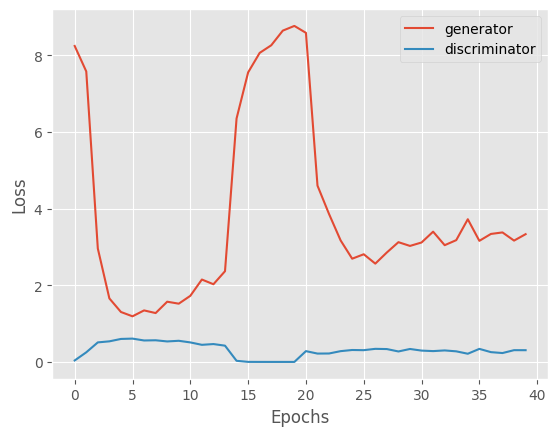

In [10]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Generating images

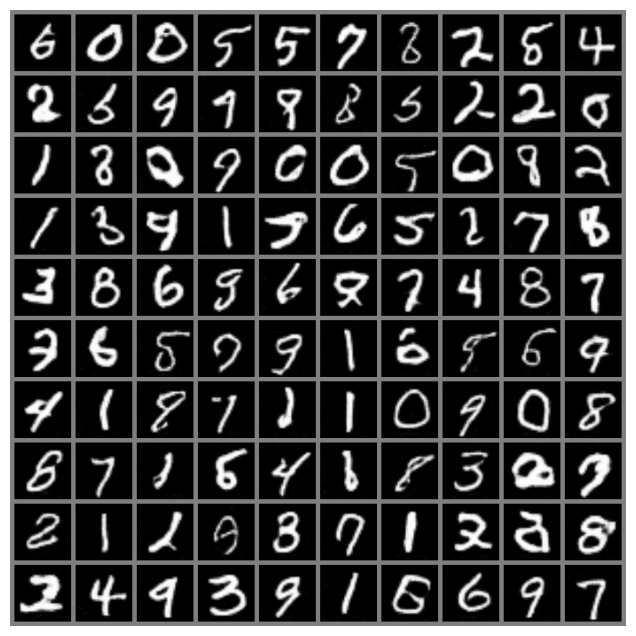

In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the standard normal distribution
    latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
    fake_image_batch = generator(latent)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
    ax.axis('off')
    plt.show()

### Interpolate in Latent Space

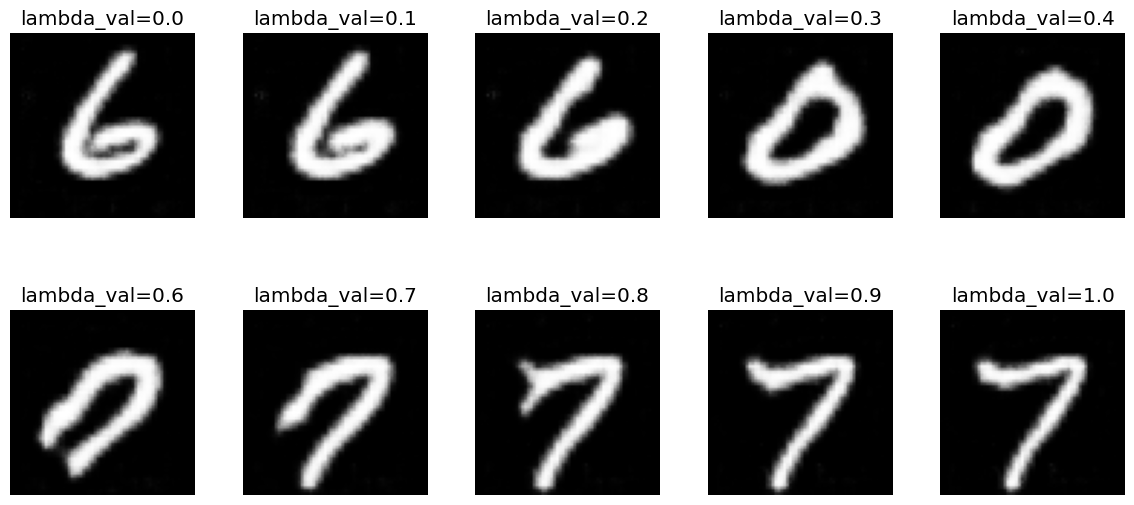

In [25]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, 100, 1, 1, device=device)
latent_2 = torch.randn(1, 100, 1, 1, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
    axs[ind].axis('off')
plt.show() 

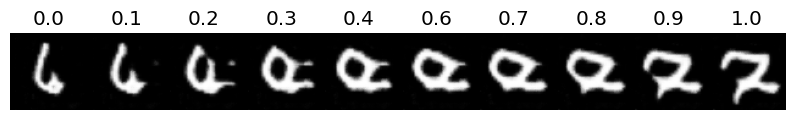

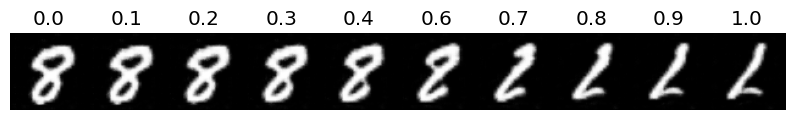

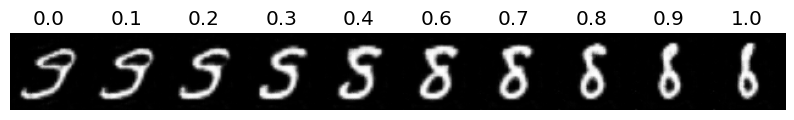

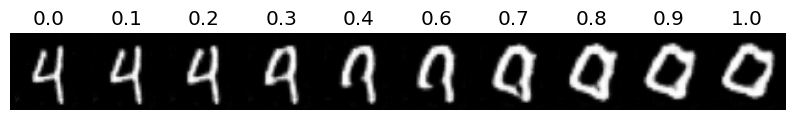

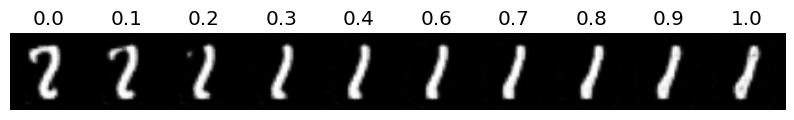

In [16]:
# @title Repeat Interpolation

rep = 5
for i in range(rep):
    # sample two latent vectors from the standard normal distribution
    latent_1 = torch.randn(1, 100, 1, 1, device=device)
    latent_2 = torch.randn(1, 100, 1, 1, device=device)

    # interpolation lambdas
    lambda_range=np.linspace(0,1,10)

    fig, axs = plt.subplots(1,10, figsize=(10, 4))
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for ind,l in enumerate(lambda_range):
        inter_image=interpolation(float(l), generator, latent_1, latent_2)
      
        inter_image = to_img(inter_image)
        
        image = inter_image.numpy()
      
        axs[ind].imshow(image[0,0,:,:], cmap='gray')
        axs[ind].set_title(str(round(l,1)))
        axs[ind].axis('off')

plt.show() 

### Save & Load Model

In [7]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/DATA303'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/DATA303


In [19]:
# Save Models
if not os.path.exists('./models'):
    os.mkdir('./models')
            
torch.save(generator.state_dict(), './models/exp0-generator.pth')
torch.save(discriminator.state_dict(),'./models/exp0-discriminator.pth')

In [8]:
# Load Models
generator.load_state_dict(torch.load('./models/exp0-generator.pth'))
discriminator.load_state_dict(torch.load('./models/exp0-discriminator.pth'))

<All keys matched successfully>

### Hyperparameter tuning

In [6]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/DATA303'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/DATA303


In [33]:
%pip install -U "ray[tune]"

from functools import partial
import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.air import session, Checkpoint

if not os.path.exists('./checkpoints'):
  os.mkdir('./checkpoints')

checkpoint_dir = './checkpoints'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
# @title LeNet
class LeNet(nn.Module):
    """
    LeNet for MNist classification, used for inception_score
    """
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [27]:
# @title Inception score
from torch.autograd import Variable
from scipy.stats import entropy
from torchvision.models.inception import inception_v3
from ray.tune.examples.pbt_dcgan_mnist.pbt_dcgan_mnist_func import download_mnist_cnn

mnist_cnn = LeNet()
model_path = download_mnist_cnn()
mnist_cnn.load_state_dict(torch.load(model_path))
mnist_cnn.eval()

def inception_score(imgs, batch_size, splits=1):
    N = len(imgs)
    dtype = torch.FloatTensor
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)
    up = nn.Upsample(size=(28, 28), mode="bilinear").type(dtype)

    def get_pred(x):
        x = up(x)
        x = mnist_cnn(x)
        return F.softmax(x).data.cpu().numpy()

    preds = np.zeros((N, 10))
    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]
        preds[i * batch_size : i * batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []
    for k in range(splits):
        part = preds[k * (N // splits) : (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

downloading model


In [28]:
# @title Training Fuction
def train(config, num_epochs=1, checkpoint_dir=None):
  # Dataloader
  train_dataloader = DataLoader(train_dataset, batch_size=config["bs"], shuffle=True)
  #test_dataloader = DataLoader(test_dataset, batch_size=config["bs"], shuffle=True)

  # Generator & Discriminator
  generator = Generator(ld=config["ld"])
  discriminator = Discriminator()

  device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
  generator = generator.to(device)
  discriminator = discriminator.to(device)

  num_params_gen = count_param(generator)
  num_params_disc = count_param(discriminator)
  print('Number of parameters for generator: {:,} and discriminator: {:,}'.format(num_params_gen, num_params_disc))

  # Optimizers
  gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=config["glr"], betas=(0.5, 0.999))
  disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=config["dlr"], betas=(0.5, 0.999))

  # Load checkpoint
  if checkpoint_dir:
    gen_state, gen_optim_state, disc_state, disc_optim_state = torch.load(
        os.path.join(checkpoint_dir, "checkpoint"))
    generator.load_state_dict(torch.load(gen_state))
    gen_optimizer.load_state_dict(torch.load(gen_optim_state))
    discriminator.load_state_dict(torch.load(disc_state))
    disc_optimizer.load_state_dict(torch.load(disc_optim_state))
  
  # Train
  generator.train()
  discriminator.train()

  gen_loss_avg = []
  disc_loss_avg = []

  print('Training ...')
  for epoch in range(num_epochs):
      gen_loss_avg.append(0)
      disc_loss_avg.append(0)
      num_batches = 0
      
      for image_batch, _ in train_dataloader:
          
          # get dataset image and create real and fake labels for use in the loss
          image_batch = image_batch.to(device)
          label_real = torch.ones(image_batch.size(0), device=device)
          label_fake = torch.zeros(image_batch.size(0), device=device)

          # generate a batch of images from samples of the latent prior
          latent = torch.randn(image_batch.size(0), config["ld"], 1, 1, device=device)
          fake_image_batch = generator(latent)
          
          # train discriminator to correctly classify real and fake
          # (detach the computation graph of the generator and the discriminator,
          # so that gradients are not backpropagated into the generator)
          real_pred = discriminator(image_batch).squeeze()
          fake_pred = discriminator(fake_image_batch.detach()).squeeze()
          disc_loss = 0.5 * (
              F.binary_cross_entropy(real_pred, label_real) +
              F.binary_cross_entropy(fake_pred, label_fake))
          
          disc_optimizer.zero_grad()
          disc_loss.backward()
          disc_optimizer.step()
          
          # train generator to output an image that is classified as real
          fake_pred = discriminator(fake_image_batch).squeeze()
          gen_loss = F.binary_cross_entropy(fake_pred, label_real)
          
          gen_optimizer.zero_grad()
          gen_loss.backward()
          gen_optimizer.step()
          
          gen_loss_avg[-1] += gen_loss.item()
          disc_loss_avg[-1] += disc_loss.item()
          num_batches += 1

          ic_score, ic_std = inception_score(fake_image_batch, config["bs"])
          
      gen_loss_avg[-1] /= num_batches
      disc_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f & Inception score = %f' %
            (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1], ic_score))
      
      with tune.checkpoint_dir(epoch) as checkpoint_dir:
        path = os.path.join(checkpoint_dir, "checkpoint")
        torch.save(generator.state_dict(), gen_optimizer.state_dict(),
                   discriminator.state_dict(), disc_optimizer.state_dict(), path)
      
  return gen_loss_avg, disc_loss_avg, ic_score

In [30]:
def hp_tuning(num_samples=10, num_train_epochs=1, max_num_epochs=10):
    # Configuring the search space
    config = {
        "bs": tune.choice([128, 256, 512]),
        "ld": tune.choice([50, 100, 150]),
        "glr": tune.choice([1e-4, 2e-4, 1e-3]),
        "dlr": tune.choice([1e-4, 2e-4, 1e-3]),
    }
    scheduler = ASHAScheduler(
        metric="ic_score",
        mode="max",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2
    )
    reporter = CLIReporter(
        # ``parameter_columns=["gen_loss", "disc_loss", "ic_score", "batch_size"]``,
        metric_columns=["gen_loss", "disc_loss", "ic_score", "training_iteration"])
    result = tune.run(
        partial(train, num_epochs=num_train_epochs),
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter
    )

    best_trial = result.get_best_trial("ic_score", "max", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final generator loss: {}".format(
        best_trial.last_result["gen_loss"]))
    print("Best trial final discriminator loss: {}".format(
        best_trial.last_result["disc_loss"]))
    print("Best trial final inception score: {}".format(
        best_trial.last_result["ic_score"]))
    
    return best_trial.config
    

    # best_trained_gen = generator(best_trial.config["ld"])
    # best_trained_gen.to(device)

    # best_checkpoint_dir = best_trial.checkpoint.value
    # model_state, optimizer_state = torch.load(os.path.join(
    #     best_checkpoint_dir, "checkpoint"))
    # best_trained_model.load_state_dict(model_state)

    # test_acc = test_accuracy(best_trained_model, device)
    # print("Best trial test set accuracy: {}".format(test_acc))

In [32]:
best_config = hp_tuning(num_samples=1, num_train_epochs=1, max_num_epochs=1)

2023-05-29 10:30:34,254	WARNING worker.py:1986 -- Warning: The actor ImplicitFunc is very large (45 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-05-29 10:30:34,484	WARNING util.py:244 -- The `start_trial` operation took 1.296 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-05-29 10:30:34 (running for 00:00:02.92)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Logical resource usage: 1.0/2 CPUs, 0/1 GPUs
Result logdir: /root/ray_results/train_2023-05-29_10-30-31
Number of trials: 1/1 (1 RUNNING)
+-------------------+----------+-------------------+------+-------+--------+------+
| Trial name        | status   | loc               |   bs |   dlr |    glr |   ld |
|-------------------+----------+-------------------+------+-------+--------+------|
| train_d6454_00000 | RUNNING  | 172.28.0.12:15157 |  128 |  0.01 | 0.0002 |  100 |
+-------------------+----------+-------------------+------+-------+--------+------+


(func pid=15157) Number of parameters for generator: 12,656,257 and discriminator: 11,033,985
(func pid=15157) Training ...
== Status ==
Current time: 2023-05-29 10:30:45 (running for 00:00:13.72)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Logical resource usage: 1.0/2 CPUs, 0/1 GPUs
R

(func pid=15157) <ipython-input-27-496ee3ed5696>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
2023-05-29 10:31:10,306	WARNING tune.py:184 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-05-29 10:31:10,322	ERROR tune.py:941 -- Trials did not complete: [train_d6454_00000]
2023-05-29 10:31:10,326	INFO tune.py:945 -- Total run time: 39.91 seconds (38.75 seconds for the tuning loop).
2023-05-29 10:31:10,329	WARNING tune.py:954 -- Experiment has been interrupted, but the most recent state was saved.
Continue running this experiment with: tune.run(..., resume=True)


== Status ==
Current time: 2023-05-29 10:31:10 (running for 00:00:38.75)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Logical resource usage: 1.0/2 CPUs, 0/1 GPUs
Result logdir: /root/ray_results/train_2023-05-29_10-30-31
Number of trials: 1/1 (1 RUNNING)
+-------------------+----------+-------------------+------+-------+--------+------+
| Trial name        | status   | loc               |   bs |   dlr |    glr |   ld |
|-------------------+----------+-------------------+------+-------+--------+------|
| train_d6454_00000 | RUNNING  | 172.28.0.12:15157 |  128 |  0.01 | 0.0002 |  100 |
+-------------------+----------+-------------------+------+-------+--------+------+


== Status ==
Current time: 2023-05-29 10:31:10 (running for 00:00:38.75)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Logical resource usage: 1.0/2 CPUs, 0/1 GPUs
Result logdir: /root/ray_results/train_2023-05-29_10-30-31
Number of trials: 1/1 (1 RUNNING)
+-------------------+----------+

KeyError: ignored

# 2. GAN (Deconv) with 28

### MNIST Data Loading

MNIST images show digits from 0-9 in 28x28 grayscale images. The images are normalized and centerd around 0, which gives a slight performance boost during training. We create both a training set and a test set.



In [34]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### GAN Architecture
Like DCGAN, we use CNNs for generator and discriminator, which generally outperform vanilla GANs with fully connected layers.

In [66]:
# @title Hyperparameters
latent_dims = 100
num_epochs = 50

In [64]:
class Generator(nn.Module):
    def __init__(self, ld, d=32):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(ld, d*2, 7, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*2)
        self.deconv2 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d)
        self.deconv3 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    def forward(self, input):
        x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = torch.tanh(self.deconv3(x))

        return x

class Discriminator(nn.Module):
    def __init__(self, d=32):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 3, 2, 1) # 14 x 14 x d
        self.conv2 = nn.Conv2d(d, d*2, 3, 2, 1) # 7 x 7 x 2d
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, 1, 7, 1, 0) # 1 x 1 x 1

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = torch.sigmoid(self.conv3(x))

        return x
    
generator = Generator(ld=latent_dims)
discriminator = Discriminator()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = count_param(generator)
num_params_disc = count_param(discriminator)
print('Number of parameters for generator: {:,} and discriminator: {:,}'.format(num_params_gen, num_params_disc))

Number of parameters for generator: 347,169 and discriminator: 22,081


In [67]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), latent_dims, 1, 1, device=device)
        fake_image_batch = generator(latent)
        
        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1
        
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))

Training ...
Epoch [1 / 50] average loss generator vs. discrim.: 1.199035 vs. 0.425621
Epoch [2 / 50] average loss generator vs. discrim.: 1.181334 vs. 0.437622
Epoch [3 / 50] average loss generator vs. discrim.: 1.166560 vs. 0.448269
Epoch [4 / 50] average loss generator vs. discrim.: 1.142046 vs. 0.461697
Epoch [5 / 50] average loss generator vs. discrim.: 1.125152 vs. 0.471987
Epoch [6 / 50] average loss generator vs. discrim.: 1.109134 vs. 0.484300
Epoch [7 / 50] average loss generator vs. discrim.: 1.092983 vs. 0.495690
Epoch [8 / 50] average loss generator vs. discrim.: 1.079496 vs. 0.502824
Epoch [9 / 50] average loss generator vs. discrim.: 1.070321 vs. 0.506877
Epoch [10 / 50] average loss generator vs. discrim.: 1.059424 vs. 0.509372
Epoch [11 / 50] average loss generator vs. discrim.: 1.048867 vs. 0.516662
Epoch [12 / 50] average loss generator vs. discrim.: 1.045119 vs. 0.518452
Epoch [13 / 50] average loss generator vs. discrim.: 1.042250 vs. 0.521929
Epoch [14 / 50] avera

### Plot Training Curves

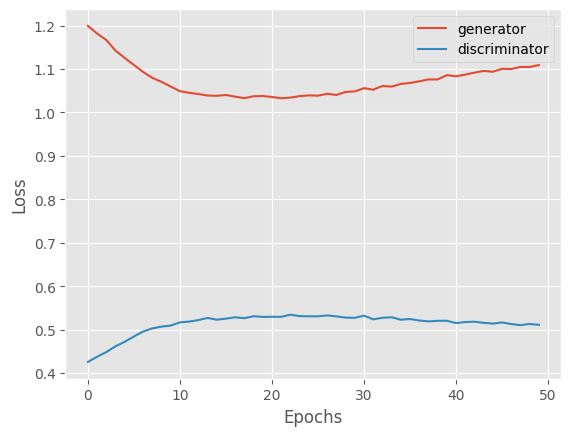

In [68]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Generating images

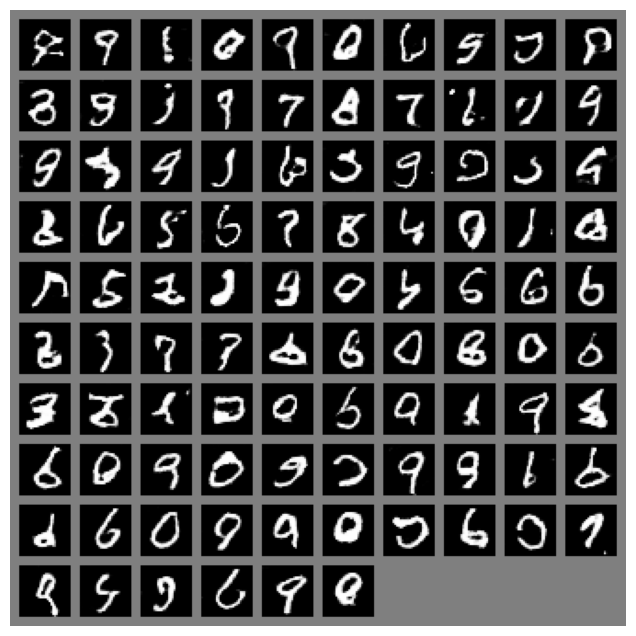

In [69]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the standard normal distribution
    latent = torch.randn(image_batch.size(0), latent_dims, 1, 1, device=device)
    fake_image_batch = generator(latent)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
    ax.axis('off')
    plt.show()

### Interpolate in Latent Space

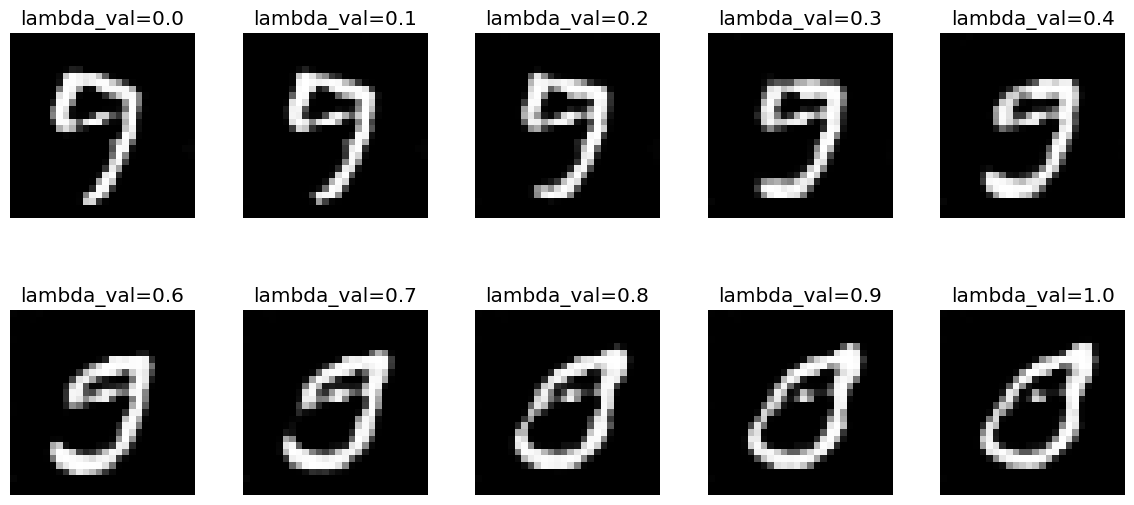

In [75]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, 100, 1, 1, device=device)
latent_2 = torch.randn(1, 100, 1, 1, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
    axs[ind].axis('off')
plt.show() 

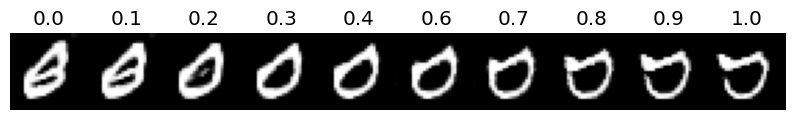

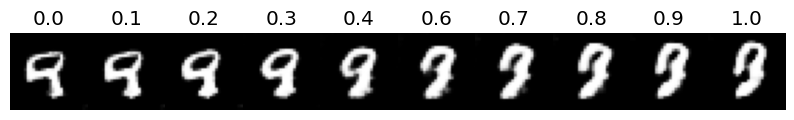

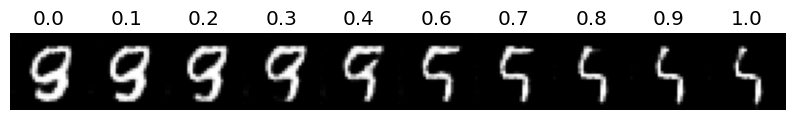

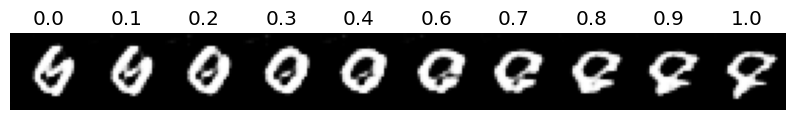

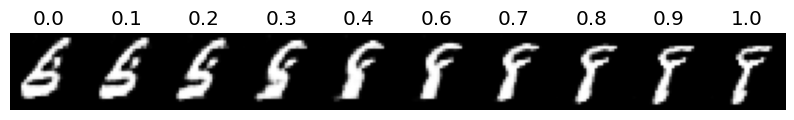

In [79]:
# @title Repeat Interpolation

rep = 5
for i in range(rep):
    # sample two latent vectors from the standard normal distribution
    latent_1 = torch.randn(1, 100, 1, 1, device=device)
    latent_2 = torch.randn(1, 100, 1, 1, device=device)

    # interpolation lambdas
    lambda_range=np.linspace(0,1,10)

    fig, axs = plt.subplots(1,10, figsize=(10, 4))
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for ind,l in enumerate(lambda_range):
        inter_image=interpolation(float(l), generator, latent_1, latent_2)
      
        inter_image = to_img(inter_image)
        
        image = inter_image.numpy()
      
        axs[ind].imshow(image[0,0,:,:], cmap='gray')
        axs[ind].set_title(str(round(l,1)))
        axs[ind].axis('off')

plt.show() 

### Save & Load Model

In [80]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/DATA303'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/DATA303


In [81]:
# Save Models
if not os.path.exists('./models'):
    os.mkdir('./models')
            
torch.save(generator.state_dict(), './models/exp2-generator.pth')
torch.save(discriminator.state_dict(),'./models/exp2-discriminator.pth')

In [82]:
# Load Models
generator.load_state_dict(torch.load('./models/exp2-generator.pth'))
discriminator.load_state_dict(torch.load('./models/exp2-discriminator.pth'))

<All keys matched successfully>

# 3. GAN (MLP) with 28

In [ ]:
# @title Hyperparameters
latent_dims = 100
num_epochs = 40

In [ ]:
# @title Define Generator and Disciminator
class GeneratorMLP(nn.Module):
    def __init__(self, ld, d=128):
        super(GeneratorMLP, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(ld, d),
            nn.LeakyReLU(0.2),
            nn.Linear(d, d*2),
            nn.LeakyReLU(0.2),
            nn.Linear(d*2, d*4),
            nn.LeakyReLU(0.2),
            nn.Linear(d*4, 28*28),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1, 28, 28)

class DiscriminatorMLP(nn.Module):
    def __init__(self, d=128):
        super(DiscriminatorMLP, self).__init__()
        self.n_input = 28*28
        self.main = nn.Sequential(
            nn.Linear(self.n_input, d*4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(d*4, d*2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(d*2, d),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(d, 1),
            nn.Sigmoid(),
        )

    def forward(self, input):
        x = input.view(-1, 28*28)
        return self.main(x)
    
generator_mlp = GeneratorMLP(ld=latent_dims)
discriminator_mlp = DiscriminatorMLP()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

generator_mlp = generator_mlp.to(device)
discriminator_mlp = discriminator_mlp.to(device)

num_params_gen_mlp = count_param(generator_mlp)
num_params_disc_mlp = count_param(discriminator_mlp)
print('Number of parameters for generator: {:,} and discriminator: {:,}'.format(num_params_gen_mlp, num_params_disc_mlp))

In [ ]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_mlp_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_mlp_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator_mlp.train()
discriminator_mlp.train()

gen_mlp_loss_avg = []
disc_mlp_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    gen_mlp_loss_avg.append(0)
    disc_mlp_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), latent_dims, 1, 1, device=device)
        fake_image_batch = generator_mlp(latent)
        
        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator_mlp(image_batch).squeeze()
        fake_pred = discriminator_mlp(fake_image_batch.detach()).squeeze()
        disc_mlp_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        
        disc_mlp_optimizer.zero_grad()
        disc_mlp_loss.backward()
        disc_mlp_optimizer.step()
        
        # train generator to output an image that is classified as real
        fake_pred = discriminator_mlp(fake_image_batch).squeeze()
        gen_mlp_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_mlp_optimizer.zero_grad()
        gen_mlp_loss.backward()
        gen_mlp_optimizer.step()
        
        gen_mlp_loss_avg[-1] += gen_mlp_loss.item()
        disc_mlp_loss_avg[-1] += disc_mlp_loss.item()
        num_batches += 1
        
    gen_mlp_loss_avg[-1] /= num_batches
    disc_mlp_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_mlp_loss_avg[-1], disc_mlp_loss_avg[-1]))

### Plot Training Curves

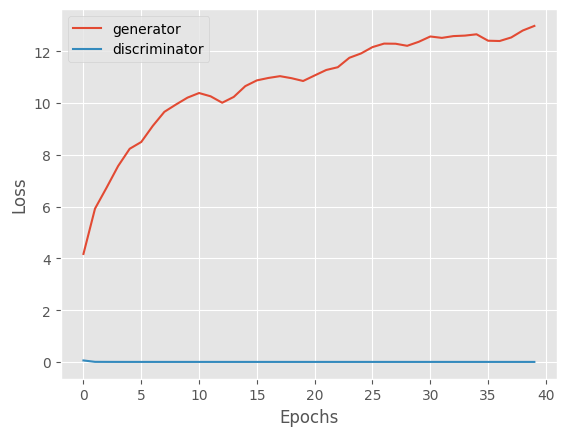

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_mlp_loss_avg, label='generator_mlp')
plt.plot(disc_mlp_loss_avg, label='discriminator_mlp')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Generating images

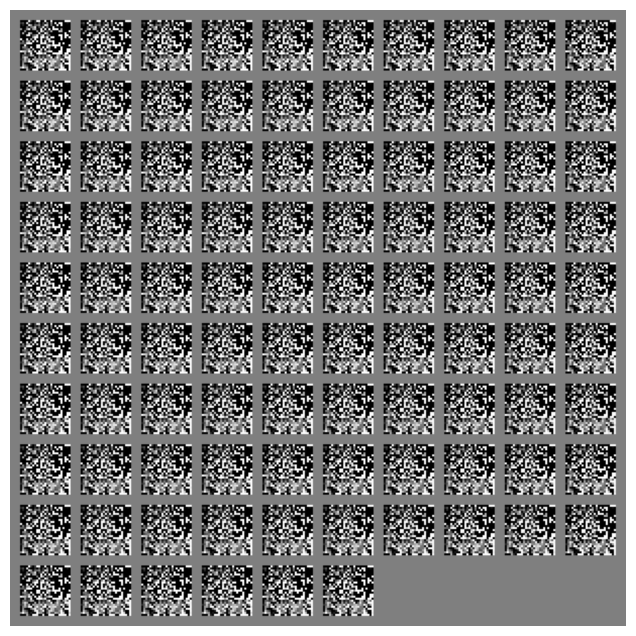

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the standard normal distribution
    latent = torch.randn(image_batch.size(0), latent_dims, 1, 1, device=device)
    fake_image_batch = generator(latent)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
    ax.axis('off')
    plt.show()

### Interpolate in Latent Space

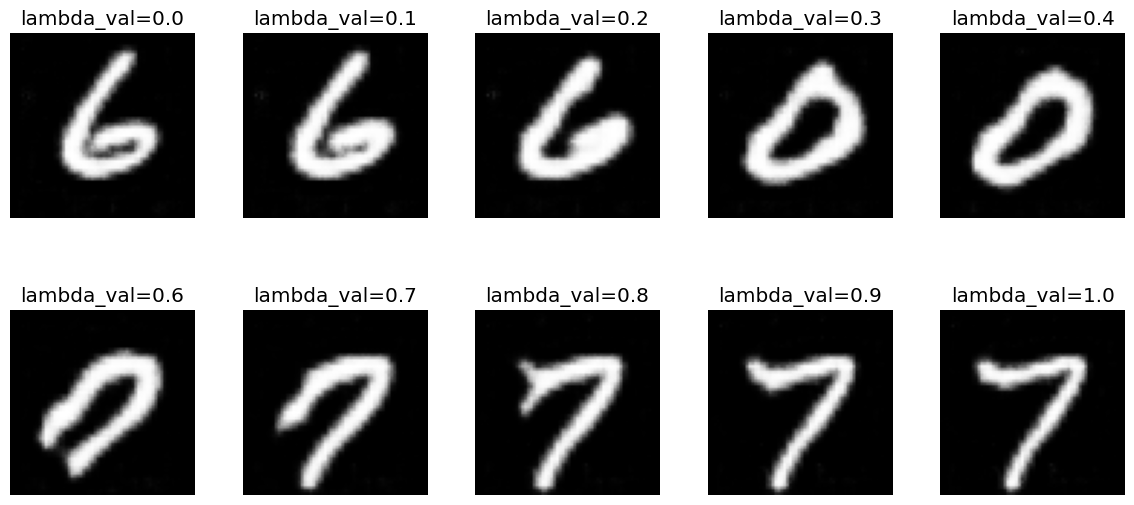

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, 100, 1, 1, device=device)
latent_2 = torch.randn(1, 100, 1, 1, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
    axs[ind].axis('off')
plt.show() 

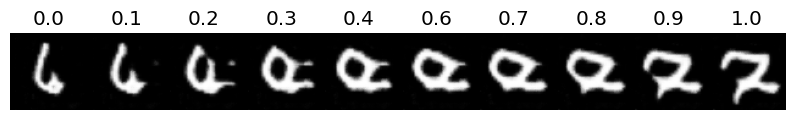

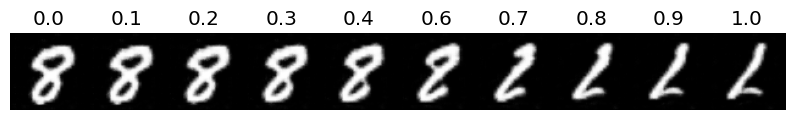

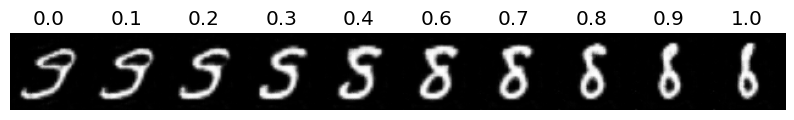

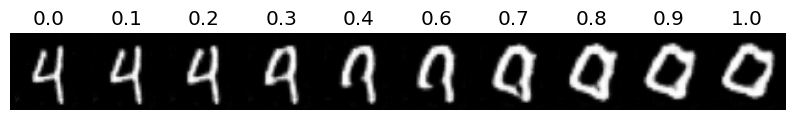

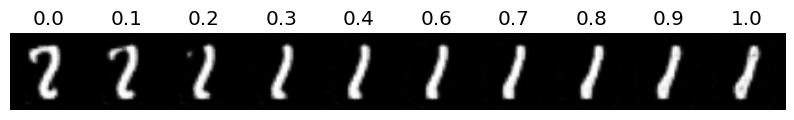

In [ ]:
# @title Repeat Interpolation

rep = 5
for i in range(rep):
    # sample two latent vectors from the standard normal distribution
    latent_1 = torch.randn(1, 100, 1, 1, device=device)
    latent_2 = torch.randn(1, 100, 1, 1, device=device)

    # interpolation lambdas
    lambda_range=np.linspace(0,1,10)

    fig, axs = plt.subplots(1,10, figsize=(10, 4))
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for ind,l in enumerate(lambda_range):
        inter_image=interpolation(float(l), generator, latent_1, latent_2)
      
        inter_image = to_img(inter_image)
        
        image = inter_image.numpy()
      
        axs[ind].imshow(image[0,0,:,:], cmap='gray')
        axs[ind].set_title(str(round(l,1)))
        axs[ind].axis('off')

plt.show() 

### Save & Load Model

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/DATA303'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/DATA303


In [ ]:
# Save Models
if not os.path.exists('./models'):
    os.mkdir('./models')
            
torch.save(generator.state_dict(), './models/exp3-generator.pth')
torch.save(discriminator.state_dict(),'./models/exp3-discriminator.pth')

In [ ]:
# Load Models
generator.load_state_dict(torch.load('./models/exp3-generator.pth'))
discriminator.load_state_dict(torch.load('./models/exp3-discriminator.pth'))

<All keys matched successfully>